In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import open3d
from intrinsics import Intrinsics
from scipy.spatial.transform import Rotation
from depth_camera import DepthCamera
import math

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<h3>Generate Aruco markers</h3>

In [2]:
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)

for i in range(3):
    markerImage = np.zeros((200, 200), dtype=np.uint8)
    markerImage = cv2.aruco.generateImageMarker(dictionary, i, 200, markerImage, 1)
    cv2.imwrite(f"aruco_markers/marker{i}.png", markerImage)

In [3]:
# depth = plt.imread("volume_tests/aruco_volume_test_depth.png")
color = cv2.imread("volume_tests/aruco_volume_test_color0.png")
color1 = cv2.imread("volume_tests/aruco_volume_test_color1.png")
color2 = cv2.imread("volume_tests/aruco_volume_test_color2.png")
color_rgb = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)

In [4]:
color1

array([[[107, 105, 122],
        [148, 146, 163],
        [132, 149, 170],
        ...,
        [ 10,  17,  13],
        [  8,  12,  11],
        [  8,  12,  11]],

       [[131, 146, 167],
        [132, 147, 168],
        [133, 148, 169],
        ...,
        [  5,  15,   3],
        [ 13,  14,  11],
        [ 10,  11,   8]],

       [[135, 150, 169],
        [134, 149, 168],
        [138, 148, 168],
        ...,
        [  3,  12,   0],
        [ 12,  14,   8],
        [ 11,  13,   7]],

       ...,

       [[ 78, 104, 139],
        [ 79, 105, 140],
        [ 88, 110, 142],
        ...,
        [ 25,  35,  57],
        [ 26,  37,  50],
        [ 25,  36,  49]],

       [[ 85, 105, 139],
        [ 87, 107, 141],
        [ 87, 109, 141],
        ...,
        [ 25,  36,  54],
        [ 22,  35,  48],
        [ 24,  37,  50]],

       [[ 76, 104, 139],
        [ 79, 107, 142],
        [ 84, 108, 142],
        ...,
        [ 24,  36,  51],
        [ 27,  39,  49],
        [ 25,  37,  47]]

(-0.5, 639.5, 479.5, -0.5)

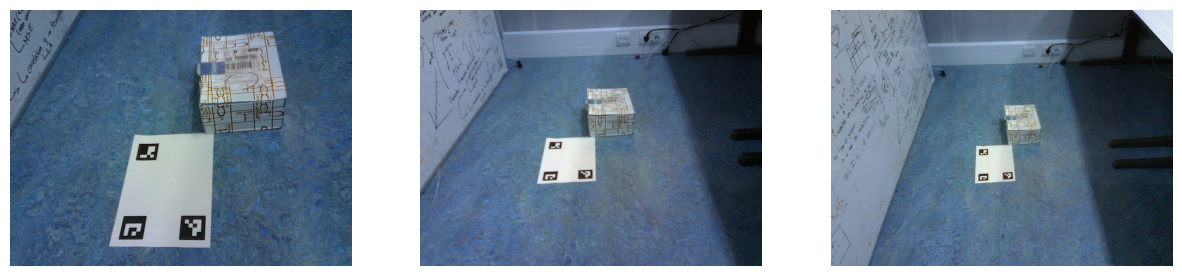

In [5]:
figs, axs = plt.subplots(1, 3, figsize=(15, 15))

axs[0].imshow(color)
axs[0].axis('off')
axs[1].imshow(color1)
axs[1].axis('off')
axs[2].imshow(color2)
axs[2].axis('off')

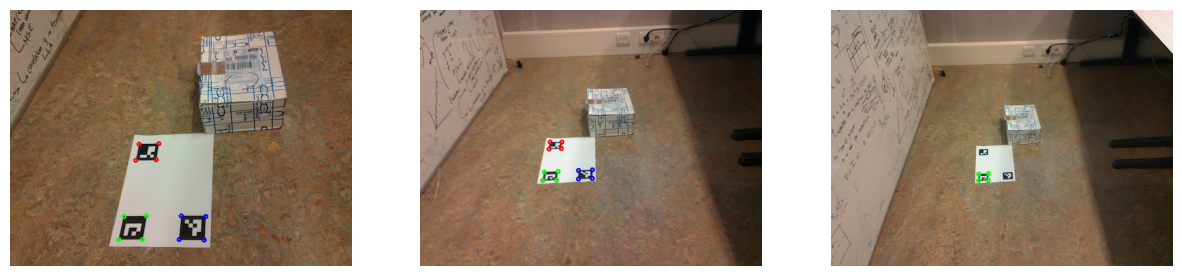

In [6]:
figs, axs = plt.subplots(1, 3, figsize=(15, 15))
imgs = [color, color1, color2]
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

for i in range(3):
    parameters =  cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, parameters)
    
    markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(imgs[i])
    marked_image = imgs[i].copy()
    for marker, id in zip(markerCorners, markerIds):
        for corner in marker.squeeze():
            marked_image = cv2.circle(marked_image, corner.astype(int), 3, colors[id[0]], 2)
            axs[i].imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
            axs[i].axis("off")

<h3>Continue with image 0 for now</h3>

In [7]:
# camera = DepthCamera()
scale = 0.00025 # or camera.depth_scale
depth = open3d.io.read_image("volume_tests/aruco_volume_test_depth0.png")

npdepth = np.asanyarray(depth)
scaled = npdepth * scale
o3d = open3d.geometry.Image(scaled.astype(np.float32))

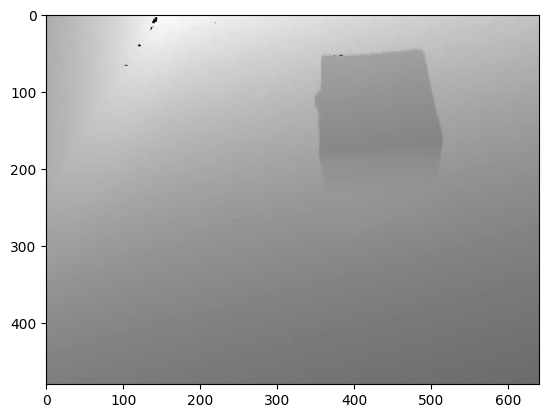

In [8]:
plt.imshow(o3d, cmap="gray")

In [9]:
intr = Intrinsics(width=640, height=480)

pcd = open3d.geometry.PointCloud.create_from_depth_image(o3d, intrinsic=intr.get_intrinsics())
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
axes = open3d.geometry.TriangleMesh.create_coordinate_frame()
# open3d.visualization.draw_geometries([pcd])

In [10]:
markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(color)

mask = np.zeros((scaled.shape[0], scaled.shape[1]))
for i in range(3):
    x = int(markerCorners[i][0][0][0])
    y = int(markerCorners[i][0][0][1])
    mask[y, x, i] = scaled[y, x]

In [11]:
marker_pcds = []

for i in range(3):
    marker_mask = open3d.geometry.Image(mask[:, :, i].astype(np.float32))
    
    m_pcd = open3d.geometry.PointCloud.create_from_depth_image(marker_mask, intrinsic=intr.get_intrinsics())
    m_pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    m_pcd.paint_uniform_color([1.0, 0, 0])
    marker_pcds.append(m_pcd)

In [12]:
points = [
    list(np.asarray(marker_pcds[0].points).squeeze()),
    list(np.asarray(marker_pcds[1].points).squeeze()),
    list(np.asarray(marker_pcds[2].points).squeeze())
]

lines = [
    [1, 2],
    [1, 0]
]

colors = [[0, 0, 1] for i in range(len(lines))]
line_set = open3d.geometry.LineSet(
    points=open3d.utility.Vector3dVector(points),
    lines=open3d.utility.Vector2iVector(lines),
)
line_set.colors = open3d.utility.Vector3dVector(colors)

# open3d.visualization.draw_geometries([line_set, pcd])

In [13]:
v_1 = np.array(points[2]) - np.array(points[1])
v_2 = np.array(points[0]) - np.array(points[1])

normal_vector = np.cross(v_1, v_2)

n_points = [
    [0, 0, 0],
    list(-10 * normal_vector)
]

n_lines = [
    [0, 1]
]

colors = [[0, 1, 0] for i in range(len(n_lines))]
n_line_set = open3d.geometry.LineSet(
    points=open3d.utility.Vector3dVector(n_points),
    lines=open3d.utility.Vector2iVector(n_lines),
)
line_set.colors = open3d.utility.Vector3dVector(colors)

# translated_n_line_set = n_line_set.translate(points[1])
axes = open3d.geometry.TriangleMesh.create_coordinate_frame()
# open3d.visualization.draw_geometries([line_set, n_line_set, pcd, axes])

In [14]:
pcd = pcd.translate(-1*np.array(points[1]))
open3d.visualization.draw_geometries([pcd, axes, n_line_set])

In [15]:
R = Rotation.align_vectors([0, 1, 0], -1*normal_vector)[0].as_matrix()

pcd.rotate(R, center=(0, 0, 0))
n_line_set.rotate(R, center=(0, 0, 0))
open3d.visualization.draw_geometries([pcd, n_line_set, axes])

In [16]:
[a, b, c] = -1*normal_vector

# alpha = -1*math.acos(y/math.sqrt(x**2 + y**2))
# beta = 0
# gamma = -1*math.acos(y/math.sqrt(y**2 + z**2))

# alpha = math.atan(x/y)
# beta = math.atan(z/x)
# gamma = -math.atan(z/y)

alpha = math.atan(a/b)
beta = math.atan(c/a)
gamma = -math.atan(c/b)

R_z = np.array([
    [math.cos(alpha), -math.sin(alpha), 0],
    [math.sin(alpha), math.cos(alpha), 0],
    [0, 0, 1]
])

R_y = np.array([
    [math.cos(beta), 0, math.sin(beta)],
    [0, 1, 0],
    [-math.sin(beta), 0, math.cos(beta)]
])

R_x = np.array([
    [1, 0, 0],
    [0, math.cos(gamma), -math.sin(gamma)],
    [0, math.sin(gamma), math.cos(gamma)]
])

R = R_z @ R_y @ R_x

# pcd = pcd.rotate(R, center=(0, 0, 0))
# n_line_set = n_line_set.rotate(R, center=(0, 0, 0))
# open3d.visualization.draw_geometries([pcd, n_line_set, axes])

pcd.rotate(R_z, center=(0, 0, 0))
n_line_set.rotate(R_z, center=(0, 0, 0))
open3d.visualization.draw_geometries([pcd, n_line_set, axes])

# pcd = pcd.rotate(R_y, center=(0, 0, 0))
# n_line_set = n_line_set.rotate(R_y, center=(0, 0, 0))
# open3d.visualization.draw_geometries([pcd, n_line_set, axes])

pcd.rotate(R_x, center=(0, 0, 0))
n_line_set = n_line_set.rotate(R_x, center=(0, 0, 0))
open3d.visualization.draw_geometries([pcd, n_line_set, axes])